In [361]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt


## Part 1

In [362]:
df = pd.read_csv("cleveland.csv")

In [363]:
df = df.rename({"num": "disease"}, axis=1)
df["disease"] = df["disease"].apply(lambda x: min(x, 1))
df
df.replace("?", pd.NA, inplace=True)
df = df.dropna()
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,1


### Standardization

In [364]:
df["thalach"] = (df.thalach - df.thalach.mean()) / df.thalach.std()
df["exang"] = (df.exang - df.exang.mean()) / df.exang.std()
df["oldpeak"] = (df.oldpeak - df.oldpeak.mean()) / df.oldpeak.std()
df["ca"] = df["ca"].astype("float")
df["thal"] = df["thal"].astype("float")
df["ca"] = (df.ca - df.ca.mean()) / df.ca.std()
df["thal"] = (df.thal - df.thal.mean()) / df.thal.std()
X = df[['thalach', 'exang', 'oldpeak', 'ca', 'thal']].values
y = df["disease"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)


## k-nearest neighbors function

In [365]:
def knn(n_neighbors, X_train, y_train, X_test, y_test):
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean", algorithm="auto")

    fit = nn.fit(X_train)

    distances, indices = fit.kneighbors(X_test)
    y_pred = []

    # print(list(y_test))

    # for i in range(len(X_test)):
    #     zeros = list(y_train.iloc[indices[i]]).count(0)
    #     ones = list(y_train.iloc[indices[i]]).count(1)
    #     if ones > zeros:
    #         y_pred.append(1)
    #     else:
    #         y_pred.append(0)
    for i in range(len(X_test)):
        zeros = list(y_train[indices[i]]).count(0)
        ones = list(y_train[indices[i]]).count(1)
        if ones > zeros:
            y_pred.append(1)
        # In case of equality of numbers we predict zero
        else:
            y_pred.append(0)
    
    (p,r,f,s) = precision_recall_fscore_support(y_test, y_pred, labels=[0,1])
    return [p, r, f, s]
    

# Finding the best K

best k -> 21


Text(0, 0.5, 'f-score')

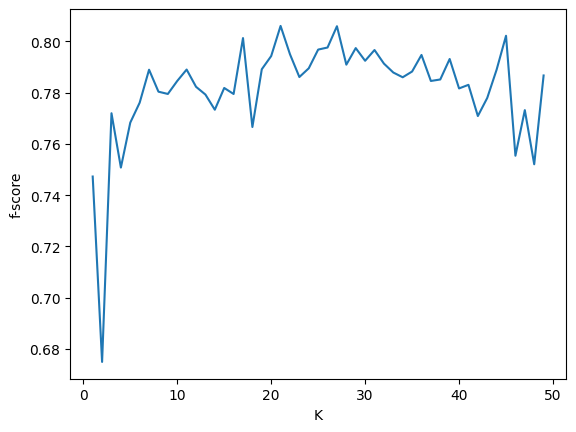

In [366]:
def bestK(n, X, y):
    k_fold = 10

    # Calculate the number of samples per fold
    fold_size = len(X) // k_fold
    
    # Shuffle the dataset
    X = np.array(X)
    y = np.array(y)

    # Shuffle the indices array
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    # Use the shuffled indices to shuffle both X and y
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    f_score_1 = []
    

    for fold in range(k_fold):
        # Split the dataset into training and testing sets for this fold
        test_start = fold * fold_size
        test_end = (fold + 1) * fold_size
        X_test_fold = X_shuffled[test_start:test_end]
        y_test_fold = y_shuffled[test_start:test_end]


        # Use the remaining data as training set
        X_train_fold = np.concatenate([X_shuffled[:test_start], X_shuffled[test_end:]])
        y_train_fold = np.concatenate([y_shuffled[:test_start], y_shuffled[test_end:]])
        result = knn(n, X_train_fold, y_train_fold, X_test_fold, y_test_fold)
        # print(result)
        f_score_1.append(result[2][1])
    
    return np.mean(f_score_1)

k_range = range(1, 50)
f_scores = [bestK(n, X, y) for n in k_range]
# print(f_scores)
print(f"best k -> {f_scores.index(max(f_scores)) + 1}")
best_K = f_scores.index(max(f_scores)) + 1

plt.plot(k_range, f_scores)
plt.xlabel("K")
plt.ylabel("f-score")




In [367]:
result = knn(best_K, X_train, y_train, X_test, y_test)
print(f'precision={result[0]}, recall={result[1]}, f-score={result[2]}, support={result[3]}') 

precision=[0.82926829 0.94736842], recall=[0.97142857 0.72      ], f-score=[0.89473684 0.81818182], support=[35 25]


### Implementation of K-fold cross validation

In [368]:
k_fold = 10

# Calculate the number of samples per fold
fold_size = len(X) // k_fold

# Shuffle the dataset
X = np.array(X)
y = np.array(y)

# Shuffle the indices array
indices = np.arange(len(X))
np.random.shuffle(indices)

# Use the shuffled indices to shuffle both X and y
X_shuffled = X[indices]
y_shuffled = y[indices]

precision_0 = []
precision_1 = []
recall_0 = []
recall_1 = []
f_score_0 = []
f_score_1 = []
support_0 = []
support_1 = []

for fold in range(k_fold):
    # Split the dataset into training and testing sets for this fold
    test_start = fold * fold_size
    test_end = (fold + 1) * fold_size
    X_test_fold = X_shuffled[test_start:test_end]
    y_test_fold = y_shuffled[test_start:test_end]
    
    
    # Use the remaining data as training set
    X_train_fold = np.concatenate([X_shuffled[:test_start], X_shuffled[test_end:]])
    y_train_fold = np.concatenate([y_shuffled[:test_start], y_shuffled[test_end:]])
    result = knn(best_K, X_train_fold, y_train_fold, X_test_fold, y_test_fold)
    # print(result)
    precision_0.append(result[0][0])
    precision_1.append(result[0][1])
    recall_0.append(result[1][0])
    recall_1.append(result[1][1])
    f_score_0.append(result[2][0])
    f_score_1.append(result[2][1])
    support_0.append(result[3][0])
    support_1.append(result[3][1])

print(f"recall_0 -> {(recall_0)}")
print(f"mean recall_0 -> {np.mean(recall_0)}")
print(f"recall_1 -> {(recall_1)}")
print(f"mean recall_1 -> {np.mean(recall_1)}")
print(f"precision_0 -> {(precision_0)}")
print(f"mean precision_0 -> {np.mean(precision_0)}")
print(f"precision_1 -> {(precision_1)}")
print(f"mean precision_1 -> {np.mean(precision_1)}")
print(f"f-score_0 -> {(f_score_0)}")
print(f"mean f-score_0 -> {np.mean(f_score_0)}")
print(f"f-score_1 -> {(f_score_1)}")
print(f"mean f-score_1 -> {np.mean(f_score_1)}")
print(f"support 0 -> {support_0}")
print(f"support 1 -> {support_1}")
    

recall_0 -> [0.8461538461538461, 0.8823529411764706, 0.9473684210526315, 0.9411764705882353, 0.9375, 0.8333333333333334, 0.7058823529411765, 0.9333333333333333, 0.9285714285714286, 0.875]
mean recall_0 -> 0.8830672127150455
recall_1 -> [0.5, 0.8333333333333334, 0.6, 0.6666666666666666, 0.8461538461538461, 0.7647058823529411, 0.75, 0.9285714285714286, 0.8, 0.8461538461538461]
mean recall_1 -> 0.7535585003232061
precision_0 -> [0.5789473684210527, 0.8823529411764706, 0.8181818181818182, 0.8, 0.8823529411764706, 0.7142857142857143, 0.8, 0.9333333333333333, 0.8125, 0.875]
mean precision_0 -> 0.809695411657486
precision_1 -> [0.8, 0.8333333333333334, 0.8571428571428571, 0.8888888888888888, 0.9166666666666666, 0.8666666666666667, 0.6428571428571429, 0.9285714285714286, 0.9230769230769231, 0.8461538461538461]
mean precision_1 -> 0.8503357753357754
f-score_0 -> [0.6875, 0.8823529411764706, 0.8780487804878049, 0.8648648648648648, 0.9090909090909091, 0.7692307692307692, 0.7500000000000001, 0.933

## Part 2

### Chronic Kidney Disease

In [369]:
# Website -> https://www.kaggle.com/datasets/mansoordaku/ckdisease?resource=download
kidneyData = pd.read_csv("kidney_disease.csv")
kidneyData
del kidneyData["id"]
kidneyData

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35,7300,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,47,6700,4.9,no,no,no,good,no,no,notckd
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,54,7800,6.2,no,no,no,good,no,no,notckd
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,49,6600,5.4,no,no,no,good,no,no,notckd
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,51,7200,5.9,no,no,no,good,no,no,notckd


### Pre-process

In [370]:
kidneyData = kidneyData.dropna()
kidneyData["rbc"] = kidneyData["rbc"].replace("normal", 1)
kidneyData["rbc"] = kidneyData["rbc"].replace("abnormal", 0)
kidneyData["pc"] = kidneyData["pc"].replace("normal", 1)
kidneyData["pc"] = kidneyData["pc"].replace("abnormal", 0)
kidneyData["pcc"] = kidneyData["pcc"].replace("present", 1)
kidneyData["pcc"] = kidneyData["pcc"].replace("notpresent", 0)
kidneyData["ba"] = kidneyData["pcc"].replace("present", 1)
kidneyData["ba"] = kidneyData["pcc"].replace("notpresent", 0)
kidneyData["htn"] = kidneyData["htn"].replace("yes", 1)
kidneyData["htn"] = kidneyData["htn"].replace("no", 0)
kidneyData["dm"] = kidneyData["dm"].replace("yes", 1)
kidneyData["dm"] = kidneyData["dm"].replace("no", 0)
kidneyData["cad"] = kidneyData["cad"].replace("yes", 1)
kidneyData["cad"] = kidneyData["cad"].replace("no", 0)
kidneyData["appet"] = kidneyData["appet"].replace("good", 1)
kidneyData["appet"] = kidneyData["appet"].replace("poor", 0)
kidneyData["pe"] = kidneyData["pe"].replace("yes", 1)
kidneyData["pe"] = kidneyData["pe"].replace("no", 0)
kidneyData["ane"] = kidneyData["ane"].replace("yes", 1)
kidneyData["ane"] = kidneyData["ane"].replace("no", 0)
kidneyData = kidneyData.rename({"classification": "disease"}, axis=1)
kidneyData["disease"] = kidneyData["disease"].replace("ckd", 1)
kidneyData["disease"] = kidneyData["disease"].replace("notckd", 0)
display(kidneyData.columns)
display(kidneyData)

C:\Users\Sadra\AppData\Local\Temp\ipykernel_15096\1620431915.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kidneyData["rbc"] = kidneyData["rbc"].replace("normal", 1)
C:\Users\Sadra\AppData\Local\Temp\ipykernel_15096\1620431915.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kidneyData["rbc"] = kidneyData["rbc"].replace("abnormal", 0)
C:\Users\Sadra\AppData\Local\Temp\ipykernel_15096\1620431915.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'disease'],
      dtype='object')

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,disease
3,48.0,70.0,1.005,4.0,0.0,1,0,1,1,117.0,...,32,6700,3.9,1,0,0,0,1,1,1
9,53.0,90.0,1.020,2.0,0.0,0,0,1,1,70.0,...,29,12100,3.7,1,1,0,0,0,1,1
11,63.0,70.0,1.010,3.0,0.0,0,0,1,1,380.0,...,32,4500,3.8,1,1,0,0,1,0,1
14,68.0,80.0,1.010,3.0,2.0,1,0,1,1,157.0,...,16,11000,2.6,1,1,1,0,1,0,1
20,61.0,80.0,1.015,2.0,0.0,0,0,0,0,173.0,...,24,9200,3.2,1,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,1,1,0,0,140.0,...,47,6700,4.9,0,0,0,1,0,0,0
396,42.0,70.0,1.025,0.0,0.0,1,1,0,0,75.0,...,54,7800,6.2,0,0,0,1,0,0,0
397,12.0,80.0,1.020,0.0,0.0,1,1,0,0,100.0,...,49,6600,5.4,0,0,0,1,0,0,0
398,17.0,60.0,1.025,0.0,0.0,1,1,0,0,114.0,...,51,7200,5.9,0,0,0,1,0,0,0


## Standardization

In [371]:
kidneyData["age"] = (kidneyData.age - kidneyData.age.mean()) / kidneyData.age.std()
kidneyData["bp"] = (kidneyData.bp - kidneyData.bp.mean()) / kidneyData.bp.std()
kidneyData["ane"] = (kidneyData.ane - kidneyData.ane.mean()) / kidneyData.ane.std()
kidneyData["bgr"] = kidneyData["bgr"].astype("float")
kidneyData["bgr"] = (kidneyData.bgr - kidneyData.bgr.mean()) / kidneyData.bgr.std()


In [372]:
X = kidneyData[["age", "bp", "ane"]].values
y = kidneyData["disease"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [373]:
result = knn(best_K, X_train, y_train, X_test, y_test)
print(f'precision={result[0]}, recall={result[1]}, f-score={result[2]}, support={result[3]}') 

precision=[0.64285714 1.        ], recall=[1.         0.28571429], f-score=[0.7826087  0.44444444], support=[18 14]


c:\Users\Sadra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sadra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sadra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

best k -> 5


c:\Users\Sadra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sadra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sadra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

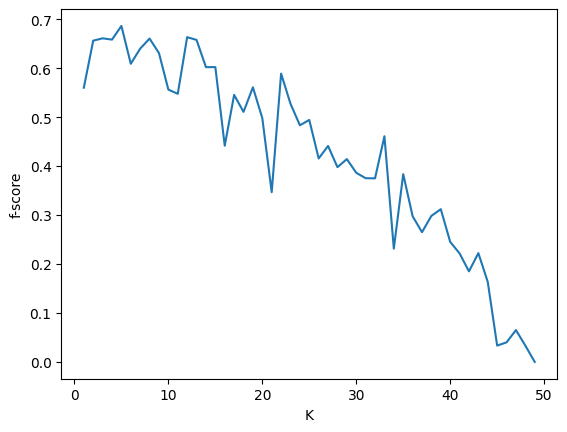

In [374]:
k_range = range(1, 50)
f_scores = [bestK(n, X, y) for n in k_range]
# print(f_scores)
best_K = f_scores.index(max(f_scores)) + 1

plt.plot(k_range, f_scores)
plt.xlabel("K")
plt.ylabel("f-score")
print(f"best k -> {f_scores.index(max(f_scores)) + 1}")

In [375]:
k_fold = 10

# Calculate the number of samples per fold
fold_size = len(X) // k_fold

# Shuffle the dataset
X = np.array(X)
y = np.array(y)

# Shuffle the indices array
indices = np.arange(len(X))
np.random.shuffle(indices)

# Use the shuffled indices to shuffle both X and y
X_shuffled = X[indices]
y_shuffled = y[indices]

precision_0 = []
precision_1 = []
recall_0 = []
recall_1 = []
f_score_0 = []
f_score_1 = []
support_0 = []
support_1 = []

for fold in range(k_fold):
    # Split the dataset into training and testing sets for this fold
    test_start = fold * fold_size
    test_end = (fold + 1) * fold_size
    X_test_fold = X_shuffled[test_start:test_end]
    y_test_fold = y_shuffled[test_start:test_end]
    
    
    # Use the remaining data as training set
    X_train_fold = np.concatenate([X_shuffled[:test_start], X_shuffled[test_end:]])
    y_train_fold = np.concatenate([y_shuffled[:test_start], y_shuffled[test_end:]])
    result = knn(best_K, X_train_fold, y_train_fold, X_test_fold, y_test_fold)
    # print(result)
    precision_0.append(result[0][0])
    precision_1.append(result[0][1])
    recall_0.append(result[1][0])
    recall_1.append(result[1][1])
    f_score_0.append(result[2][0])
    f_score_1.append(result[2][1])
    support_0.append(result[3][0])
    support_1.append(result[3][1])

print(f"recall_0 -> {(recall_0)}")
print(f"mean recall_0 -> {np.mean(recall_0)}")
print(f"recall_1 -> {(recall_1)}")
print(f"mean recall_1 -> {np.mean(recall_1)}")
print(f"precision_0 -> {(precision_0)}")
print(f"mean precision_0 -> {np.mean(precision_0)}")
print(f"precision_1 -> {(precision_1)}")
print(f"mean precision_1 -> {np.mean(precision_1)}")
print(f"f-score_0 -> {(f_score_0)}")
print(f"mean f-score_0 -> {np.mean(f_score_0)}")
print(f"f-score_1 -> {(f_score_1)}")
print(f"mean f-score_1 -> {np.mean(f_score_1)}")
print(f"support 0 -> {support_0}")
print(f"support 1 -> {support_1}")


recall_0 -> [0.9, 1.0, 1.0, 0.9, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0]
mean recall_0 -> 0.97
recall_1 -> [0.4, 0.6666666666666666, 0.4444444444444444, 0.2, 0.5, 0.5, 0.8, 1.0, 1.0, 0.0]
mean recall_1 -> 0.5511111111111111
precision_0 -> [0.75, 0.9230769230769231, 0.5454545454545454, 0.6923076923076923, 0.9285714285714286, 0.9285714285714286, 0.9, 1.0, 1.0, 0.8]
mean precision_0 -> 0.8467982017982019
precision_1 -> [0.6666666666666666, 1.0, 1.0, 0.5, 1.0, 1.0, 0.8, 1.0, 1.0, 0.0]
mean precision_1 -> 0.7966666666666666
f-score_0 -> [0.8181818181818182, 0.9600000000000001, 0.7058823529411764, 0.7826086956521738, 0.962962962962963, 0.962962962962963, 0.9, 1.0, 1.0, 0.888888888888889]
mean f-score_0 -> 0.8981487681589984
f-score_1 -> [0.5, 0.8, 0.6153846153846153, 0.28571428571428575, 0.6666666666666666, 0.6666666666666666, 0.8000000000000002, 1.0, 1.0, 0.0]
mean f-score_1 -> 0.6334432234432235
support 0 -> [10, 12, 6, 10, 13, 13, 10, 13, 11, 12]
support 1 -> [5, 3, 9, 5, 2, 2, 5, 2, 4, 3]


c:\Users\Sadra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
